# Praca domowa 1

## Karol Degórski

### Import potrzebnych pakietów

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

### Stworzenie danych XOR i pobranie iris

In [2]:
# Ustawienie ziarna losowości
torch.manual_seed(7)
np.random.seed(7)

#### XOR

In [3]:
x = np.random.uniform(-1, 1, (2000,3))

In [4]:
x[:,2] = np.sign(x[:,0]).astype(int) * np.sign(x[:,1]).astype(int)
x[:,2] = np.where(x[:,2] == -1, 0, 1)

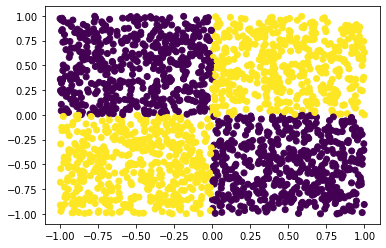

In [5]:
plt.scatter(x[:,0], x[:,1], c=x[:,2])

In [6]:
x_xor = x[:,(0,1)]
y_xor = x[:,2]

In [7]:
x_xor_train, x_xor_test, y_xor_train, y_xor_test = train_test_split(x_xor, y_xor, test_size=0.30, random_state=10)

In [8]:
x_xor_tensor = torch.as_tensor(x_xor, dtype=torch.float32)
y_xor_tensor = torch.as_tensor(y_xor, dtype=torch.float32)

#### iris

In [9]:
from sklearn import datasets

In [10]:
iris = datasets.load_iris()
x_iris = iris.data
y_iris = iris.target

In [11]:
# Skalujemy dane
scaler = StandardScaler()
x_iris = scaler.fit_transform(x_iris)

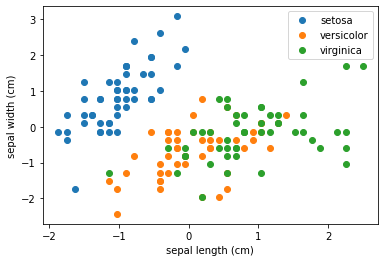

In [12]:
for target, target_name in enumerate(iris['target_names']):
    X_plot = x_iris[y_iris == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
    plt.xlabel(iris['feature_names'][0])
    plt.ylabel(iris['feature_names'][1])
plt.legend();

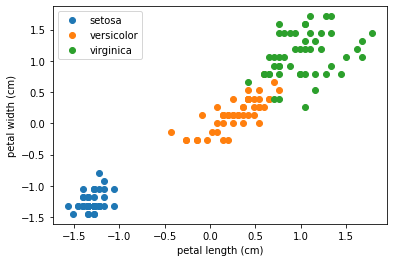

In [13]:
for target, target_name in enumerate(iris['target_names']):
    X_plot = x_iris[y_iris == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
    plt.xlabel(iris['feature_names'][2])
    plt.ylabel(iris['feature_names'][3])
plt.legend();

In [14]:
x_iris_train, x_iris_test, y_iris_train, y_iris_test = train_test_split(x_iris, y_iris, test_size=0.30, random_state=10)

In [15]:
x_iris_tensor = torch.as_tensor(x_iris, dtype=torch.float32)
y_iris_tensor = torch.as_tensor(y_iris, dtype=torch.float32)

### Stworzenie modelu

#### XOR

In [16]:
X_train_xor, X_test_xor = torch.from_numpy(x_xor_train).type(torch.float32), torch.from_numpy(x_xor_test).type(torch.float32)
y_train_xor, y_test_xor = torch.from_numpy(y_xor_train).type(torch.float32), torch.from_numpy(y_xor_test).type(torch.float32)

In [17]:
torch.manual_seed(1)
np.random.seed(1)

net = torch.nn.Sequential(
    torch.nn.Linear(2, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 2),
    torch.nn.Softmax(dim=1)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

learning_rate = 0.05
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

num_iter = 200
batch_size = 64

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    net.eval()
    for batch in range(int(X_train_xor.shape[0] / batch_size)):
        X = X_train_xor[batch*batch_size:((batch+1)*batch_size),]
        y = y_train_xor[batch*batch_size:((batch+1)*batch_size),]
        y_hat = net(X)
        errors_train_iter += [torch.nn.functional.mse_loss(y, y_hat[:,0]).item()]

    for batch in range(int(X_test_xor.shape[0] / batch_size)):
        X = X_test_xor[batch*batch_size:((batch+1)*batch_size),]
        y = y_test_xor[batch*batch_size:((batch+1)*batch_size),]
        y_hat = net(X)
        errors_test_iter += [torch.nn.functional.mse_loss(y, y_hat[:,0]).item()]

    net.train()
    for batch in range(int(X_train_xor.shape[0] / batch_size)):
        X = X_train_xor[batch*batch_size:((batch+1)*batch_size),]
        y = y_train_xor[batch*batch_size:((batch+1)*batch_size),]
        y_hat = net(X)
        l = loss(y_hat[:,0], y)
        optimizer.zero_grad()
        l.mean().backward()
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]


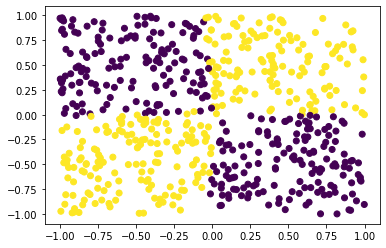

In [18]:
y_hat = net(X_test_xor)
y_hat = y_hat.detach().numpy()

y_hat[y_hat > 0.5] = 1
y_hat[y_hat <= 0.5] = 0

plt.scatter(x_xor_test[:,0], x_xor_test[:,1], c=y_hat[:,0])

#### iris

In [19]:
X_train_iris, X_test_iris = torch.from_numpy(x_iris_train).type(torch.float32), torch.from_numpy(x_iris_test).type(torch.float32)
y_train_iris, y_test_iris = torch.from_numpy(y_iris_train).long(), torch.from_numpy(y_iris_test).long()

In [20]:
torch.manual_seed(1)
np.random.seed(1)

net2 = torch.nn.Sequential(
    torch.nn.Linear(4, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 3),
    torch.nn.Softmax(dim=1)
)


net2.apply(init_weights)

learning_rate = 0.001
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=learning_rate)

num_iter = 200
batch_size = 64

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    net2.eval()
    for batch in range(int(X_train_iris.shape[0] / batch_size)):
        X = X_train_iris[batch*batch_size:((batch+1)*batch_size),]
        y = y_train_iris[batch*batch_size:((batch+1)*batch_size),]
        y_hat = net2(X)
        errors_train_iter += [torch.nn.functional.mse_loss(y, y_hat[:,0]).item()]

    for batch in range(int(X_test_iris.shape[0] / batch_size)):
        X = X_test_iris[batch*batch_size:((batch+1)*batch_size),]
        y = y_test_iris[batch*batch_size:((batch+1)*batch_size),]
        y_hat = net2(X)
        errors_test_iter += [torch.nn.functional.mse_loss(y, y_hat[:,0]).item()]

    net2.train()
    for batch in range(int(X_train_iris.shape[0] / batch_size)):
        X = X_train_iris[batch*batch_size:((batch+1)*batch_size),]
        y = y_train_iris[batch*batch_size:((batch+1)*batch_size),]
        y_hat = net2(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    
    errors_train += [errors_train_iter]
    errors_test += [errors_test_iter]

In [21]:
y_hat_iris = net2(X_test_iris)
y_hat_iris = y_hat_iris.detach().numpy()
y_hat_iris[y_hat_iris > 0.5] = 1
y_hat_iris[y_hat_iris <= 0.5] = 0

In [22]:
y_hat_iris = np.argmax(y_hat_iris, axis=1)

In [23]:
confusion_matrix(y_iris_test, y_hat_iris)

array([[14,  0,  0],
       [ 5,  8,  4],
       [ 0,  0, 14]])

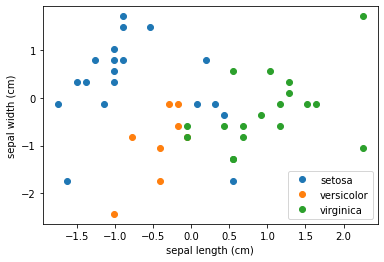

In [24]:
for target, target_name in enumerate(iris['target_names']):
    X_plot = x_iris_test[y_hat_iris == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
    plt.xlabel(iris['feature_names'][0])
    plt.ylabel(iris['feature_names'][1])
plt.legend();

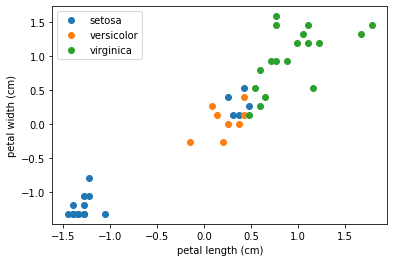

In [25]:
for target, target_name in enumerate(iris['target_names']):
    X_plot = x_iris_test[y_hat_iris == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
    plt.xlabel(iris['feature_names'][2])
    plt.ylabel(iris['feature_names'][3])
plt.legend();

### Porównawnanie różnych architektur sieci neuronowych (liczby neuronów i warstw)

#### XOR

In [26]:
# Zdefinowanie trenowania modelu w funckji aby łatwiej było zmieniać parametry
torch.manual_seed(1)
np.random.seed(1)

def train_and_predict_model_xor(net, X_train, y_train, X_test, y_test, learning_rate, num_iter):

    net.apply(init_weights)

    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    batch_size = 64

    losses = []
    errors_train = []
    errors_test = []

    for epoch in range(num_iter):
        losses_iter = []
        errors_train_iter = []
        errors_test_iter = []
    
        net.eval()
        for batch in range(int(X_train.shape[0] / batch_size)):
            X = X_train[batch*batch_size:((batch+1)*batch_size),]
            y = y_train[batch*batch_size:((batch+1)*batch_size),]
            y_hat = net(X)
            errors_train_iter += [torch.nn.functional.mse_loss(y, y_hat[:,0]).item()]

        for batch in range(int(X_test.shape[0] / batch_size)):
            X = X_test[batch*batch_size:((batch+1)*batch_size),]
            y = y_test[batch*batch_size:((batch+1)*batch_size),]
            y_hat = net(X)
            errors_test_iter += [torch.nn.functional.mse_loss(y, y_hat[:,0]).item()]

        net.train()
        for batch in range(int(X_train.shape[0] / batch_size)):
            X = X_train[batch*batch_size:((batch+1)*batch_size),]
            y = y_train[batch*batch_size:((batch+1)*batch_size),]
            y_hat = net(X)
            l = loss(y_hat[:,0], y)
            optimizer.zero_grad()
            l.mean().backward()
            optimizer.step()
    
        errors_train += [np.mean(errors_train_iter)]
        errors_test += [np.mean(errors_test_iter)]

    y_hat = net(X_test)
    y_hat = y_hat.detach().numpy()

    y_hat[y_hat > 0.5] = 1
    y_hat[y_hat <= 0.5] = 0
    
    return y_hat


##### 2 warstwy ukryte: (2, 4) i (4, 2)

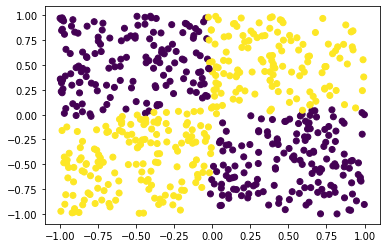

In [27]:
torch.manual_seed(1)
np.random.seed(1)
net = torch.nn.Sequential(
        torch.nn.Linear(2, 4),
        torch.nn.ReLU(),
        torch.nn.Linear(4, 2),
        torch.nn.Softmax(dim=1)
    )
y_hat = train_and_predict_model_xor(net, X_train_xor, y_train_xor, X_test_xor, y_test_xor, 0.05, 20)
plt.scatter(x_xor_test[:,0], x_xor_test[:,1], c=y_hat[:,0])

##### 3 warstwy ukryte: (2,8), (8, 4) i (4,2)

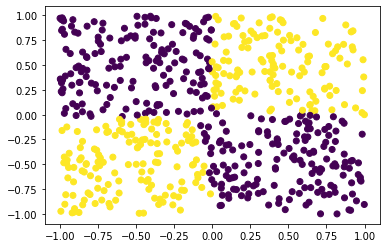

In [28]:
torch.manual_seed(1)
np.random.seed(1)
net = torch.nn.Sequential(
        torch.nn.Linear(2, 8),
        torch.nn.ReLU(),
        torch.nn.Linear(8, 4),
        torch.nn.ReLU(),
        torch.nn.Linear(4, 2),
        torch.nn.Softmax(dim=1)
    )
y_hat = train_and_predict_model_xor(net, X_train_xor, y_train_xor, X_test_xor, y_test_xor, 0.05, 20)
plt.scatter(x_xor_test[:,0], x_xor_test[:,1], c=y_hat[:,0])

Nie zawsze dodanie kolejnej warstwy neuronów polepsza predykcję

##### 3 warstwy ukryte: (2,4), (4, 4) i (4,2)

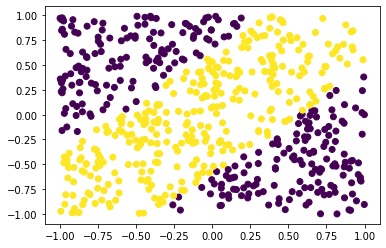

In [29]:
torch.manual_seed(1)
np.random.seed(1)
net = torch.nn.Sequential(
        torch.nn.Linear(2, 4),
        torch.nn.ReLU(),
        torch.nn.Linear(4, 4),
        torch.nn.ReLU(),
        torch.nn.Linear(4, 2),
        torch.nn.Softmax(dim=1)
    )
y_hat = train_and_predict_model_xor(net, X_train_xor, y_train_xor, X_test_xor, y_test_xor, 0.05, 20)
plt.scatter(x_xor_test[:,0], x_xor_test[:,1], c=y_hat[:,0])

Nie zawsze dodanie kolejnej warstwy neuronów polepsza predykcję. W tym przypadku nawet mamy pogorszenie

#### iris

In [30]:
# Zdefinowanie trenowania modelu w funckji aby łatwiej było zmieniać parametry
torch.manual_seed(1)
np.random.seed(1)

def train_and_predict_model_iris(net, X_train, y_train, X_test, y_test, learning_rate, num_iter):

    net.apply(init_weights)

    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    batch_size = 64

    losses = []
    errors_train = []
    errors_test = []

    for epoch in range(num_iter):
        losses_iter = []
        errors_train_iter = []
        errors_test_iter = []
    
        net.eval()
        for batch in range(int(X_train.shape[0] / batch_size)):
            X = X_train[batch*batch_size:((batch+1)*batch_size),]
            y = y_train[batch*batch_size:((batch+1)*batch_size),]
            y_hat = net(X)
            errors_train_iter += [torch.nn.functional.mse_loss(y, y_hat[:,0]).item()]

        for batch in range(int(X_test.shape[0] / batch_size)):
            X = X_test[batch*batch_size:((batch+1)*batch_size),]
            y = y_test[batch*batch_size:((batch+1)*batch_size),]
            y_hat = net(X)
            errors_test_iter += [torch.nn.functional.mse_loss(y, y_hat[:,0]).item()]

        net.train()
        for batch in range(int(X_train.shape[0] / batch_size)):
            X = X_train[batch*batch_size:((batch+1)*batch_size),]
            y = y_train[batch*batch_size:((batch+1)*batch_size),]
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
    
        errors_train += [errors_train_iter]
        errors_test += [errors_test_iter]
    
    y_hat_iris = net(X_test)
    y_hat_iris = y_hat_iris.detach().numpy()
    y_hat_iris[y_hat_iris > 0.5] = 1
    y_hat_iris[y_hat_iris <= 0.5] = 0

    y_hat_iris = np.argmax(y_hat_iris, axis=1)

    return y_hat_iris

##### 2 warstwy ukryte: (4, 50) i (50, 3)

In [31]:
torch.manual_seed(1)
np.random.seed(1)
net2 = torch.nn.Sequential(
    torch.nn.Linear(4, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 3),
    torch.nn.Softmax(dim=1)
)
y_hat_iris = train_and_predict_model_iris(net2, X_train_iris, y_train_iris, X_test_iris, y_test_iris, 0.001, 200)
confusion_matrix(y_iris_test, y_hat_iris)

array([[14,  0,  0],
       [ 5,  8,  4],
       [ 0,  0, 14]])

##### 3 warstwy ukryte: (4, 50), (50, 25) i (25, 3)

In [32]:
torch.manual_seed(1)
np.random.seed(1)
net2 = torch.nn.Sequential(
    torch.nn.Linear(4, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 3),
    torch.nn.Softmax(dim=1)
)
y_hat_iris = train_and_predict_model_iris(net2, X_train_iris, y_train_iris, X_test_iris, y_test_iris, 0.001, 200)
confusion_matrix(y_iris_test, y_hat_iris)

array([[14,  0,  0],
       [ 0, 16,  1],
       [ 0,  0, 14]])

W tym przypadku po dodaniu warstwy neuronów udało nam się polepszyć predykcję

##### 3 warstwy ukryte: (4, 100) i (100, 3)

In [33]:
torch.manual_seed(1)
np.random.seed(1)
net2 = torch.nn.Sequential(
    torch.nn.Linear(4, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 3),
    torch.nn.Softmax(dim=1)
)
y_hat_iris = train_and_predict_model_iris(net2, X_train_iris, y_train_iris, X_test_iris, y_test_iris, 0.001, 200)
confusion_matrix(y_iris_test, y_hat_iris)

array([[14,  0,  0],
       [ 0, 15,  2],
       [ 0,  0, 14]])

Dodanie neuronów również polepszyło predykcję w stosunku do pierwszej predykcji

##### 4 warstwy ukryte: (4, 50), (50, 50), (50, 100) i (100, 3)

In [34]:
torch.manual_seed(1)
np.random.seed(1)
net2 = torch.nn.Sequential(
    torch.nn.Linear(4, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 3),
    torch.nn.Softmax(dim=1)
)
y_hat_iris = train_and_predict_model_iris(net2, X_train_iris, y_train_iris, X_test_iris, y_test_iris, 0.001, 200)
confusion_matrix(y_iris_test, y_hat_iris)

array([[14,  0,  0],
       [ 0, 16,  1],
       [ 0,  0, 14]])

Po zwiększeniu liczby neuronów udało się zaklasyfikować praktycznie wszystkie obserwacje poprawnie

### Porównawnanie różnych wartości learning_rate

#### XOR

##### learning rate 0.05

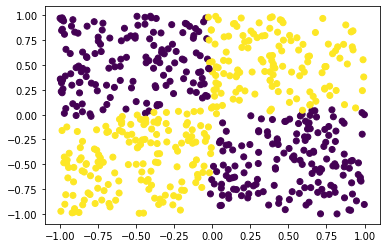

In [35]:
torch.manual_seed(1)
np.random.seed(1)
net = torch.nn.Sequential(
        torch.nn.Linear(2, 4),
        torch.nn.ReLU(),
        torch.nn.Linear(4, 2),
        torch.nn.Softmax(dim=1)
    )
y_hat = train_and_predict_model_xor(net, X_train_xor, y_train_xor, X_test_xor, y_test_xor, 0.05, 20)
plt.scatter(x_xor_test[:,0], x_xor_test[:,1], c=y_hat[:,0])

Znaleziony przeze mnie optymalny poziom learning rate 0,05

##### learning rate 0.001

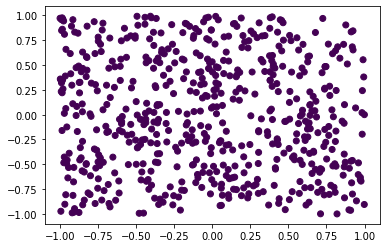

In [36]:
torch.manual_seed(1)
np.random.seed(1)
net = torch.nn.Sequential(
        torch.nn.Linear(2, 4),
        torch.nn.ReLU(),
        torch.nn.Linear(4, 2),
        torch.nn.Softmax(dim=1)
    )
y_hat = train_and_predict_model_xor(net, X_train_xor, y_train_xor, X_test_xor, y_test_xor, 0.001, 20)
plt.scatter(x_xor_test[:,0], x_xor_test[:,1], c=y_hat[:,0])

Przy 20 epokach learning rate 0,001 okazuje się być zbyt mały - model nie dzieli zbioru na klasy. Spróbujmy zwiększyć zatem liczbę epok

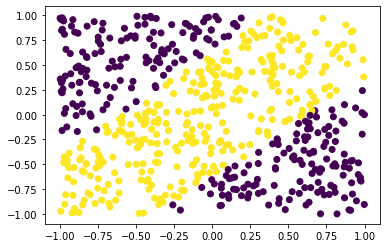

In [37]:
torch.manual_seed(1)
np.random.seed(1)
net = torch.nn.Sequential(
        torch.nn.Linear(2, 4),
        torch.nn.ReLU(),
        torch.nn.Linear(4, 2),
        torch.nn.Softmax(dim=1)
    )
y_hat = train_and_predict_model_xor(net, X_train_xor, y_train_xor, X_test_xor, y_test_xor, 0.001, 200)
plt.scatter(x_xor_test[:,0], x_xor_test[:,1], c=y_hat[:,0])

Zwiększenie liczby epok do 200 okazuje się być niewystarczające. Model dalej prawidłowo nie dzieli zbioru.

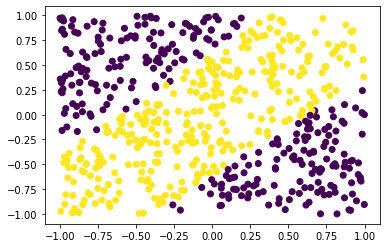

In [38]:
torch.manual_seed(1)
np.random.seed(1)
net = torch.nn.Sequential(
        torch.nn.Linear(2, 4),
        torch.nn.ReLU(),
        torch.nn.Linear(4, 2),
        torch.nn.Softmax(dim=1)
    )
y_hat = train_and_predict_model_xor(net, X_train_xor, y_train_xor, X_test_xor, y_test_xor, 0.001, 1000)
plt.scatter(x_xor_test[:,0], x_xor_test[:,1], c=y_hat[:,0])

Dalej nie ma poprawy przy 1000 epokach.

##### learning rate 0.1

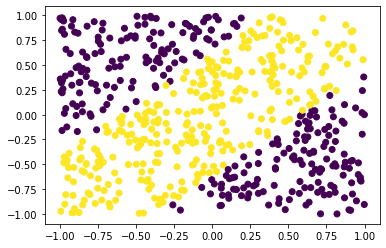

In [39]:
torch.manual_seed(1)
np.random.seed(1)
net = torch.nn.Sequential(
        torch.nn.Linear(2, 4),
        torch.nn.ReLU(),
        torch.nn.Linear(4, 2),
        torch.nn.Softmax(dim=1)
    )
y_hat = train_and_predict_model_xor(net, X_train_xor, y_train_xor, X_test_xor, y_test_xor, 0.1, 20)
plt.scatter(x_xor_test[:,0], x_xor_test[:,1], c=y_hat[:,0])

Learning rate jest za duży - model nie znajduje poprawnej klasyfikacji

#### iris

##### learning rate 0.001

In [40]:
torch.manual_seed(1)
np.random.seed(1)
net2 = torch.nn.Sequential(
    torch.nn.Linear(4, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 3),
    torch.nn.Softmax(dim=1)
)
y_hat_iris = train_and_predict_model_iris(net2, X_train_iris, y_train_iris, X_test_iris, y_test_iris, 0.001, 200)
confusion_matrix(y_iris_test, y_hat_iris)

array([[14,  0,  0],
       [ 5,  8,  4],
       [ 0,  0, 14]])

Wyznaczony przeze mnie wcześniej learning rate

##### learning rate 0.0001

In [41]:
torch.manual_seed(1)
np.random.seed(1)
net2 = torch.nn.Sequential(
    torch.nn.Linear(4, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 3),
    torch.nn.Softmax(dim=1)
)
y_hat_iris = train_and_predict_model_iris(net2, X_train_iris, y_train_iris, X_test_iris, y_test_iris, 0.0001, 200)
confusion_matrix(y_iris_test, y_hat_iris)

array([[14,  0,  0],
       [17,  0,  0],
       [14,  0,  0]])

Jest to za mały poziom learning rate - model nie klasyfikuje poprawnie danych

##### learning rate 0.1

In [42]:
torch.manual_seed(1)
np.random.seed(1)
net2 = torch.nn.Sequential(
    torch.nn.Linear(4, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 3),
    torch.nn.Softmax(dim=1)
)
y_hat_iris = train_and_predict_model_iris(net2, X_train_iris, y_train_iris, X_test_iris, y_test_iris, 0.1, 200)
confusion_matrix(y_iris_test, y_hat_iris)

array([[13,  1,  0],
       [ 0, 16,  1],
       [ 0,  0, 14]])

Poziom 0,1 daje lepsze wyniki niż wyznaczony wcześniej poziom 0,001

Podsumowując znalezienie właściwego poziomu learning rate nie jest łatwym zadaniem, ale jest to kluczowe do otrzymania satysfakcjonujących wyników.

### Wytrenowanie modelu na zbiorze danych MNIST i analiza macierzy pomyłek tej klasyfikacji

In [60]:
import torchvision

In [61]:
mnist_train = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=torchvision.transforms.ToTensor(), download=True
)
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [62]:
examplary_dataloader_train = torch.utils.data.DataLoader(mnist_train, batch_size=1)
X, y = next(iter(examplary_dataloader_train))
{'image': X, 'class': y}

{'image': tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
            0.2863, 

In [63]:
np.random.seed(1)
torch.manual_seed(1)

net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 10)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=10, bias=True)
)

In [64]:
learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [65]:
torch.manual_seed(123)
np.random.seed(123)

num_iter = 20
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=2)

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for X, y in dataloader_test:
        y_hat = net(X)
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for X, y in dataloader_train:
        y_hat = net(X)
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        
    for X, y in dataloader_train:
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

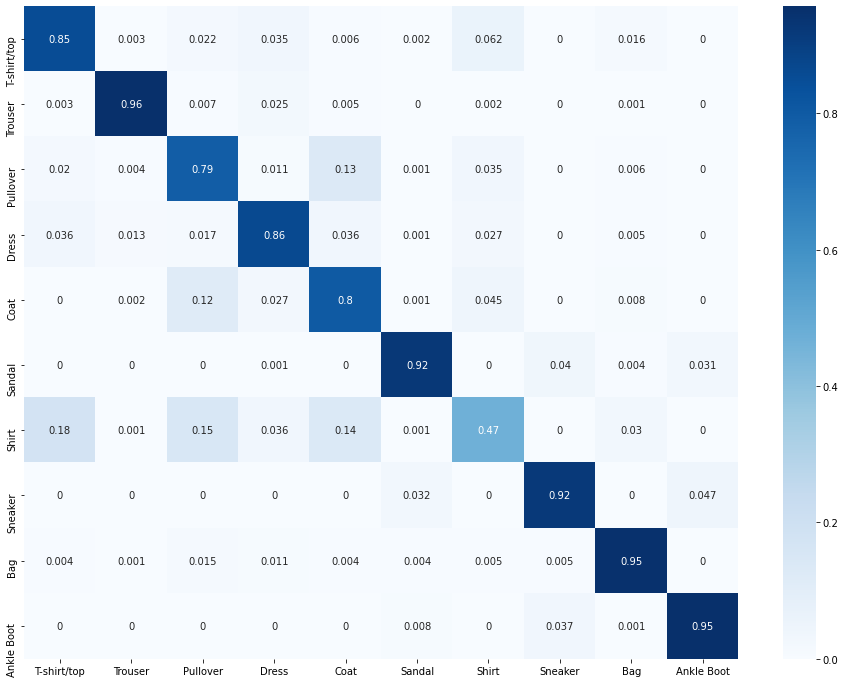

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloader_test:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (16, 12))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

Interpretacja:
- główna przekątna zawiera informacje o procencie prawidłowo zakwalifikowanych towarów (ogólnie udało się całkiem dobrze zaklasyfikować produkty)
- widzimy, że największy problem model miał ze sklasyfikowaniem koszul - tylko 47% jest prawidłowo sklasyfikowanych)
- najlepiej zostały sklasyfikowane spodnie, trzewiki, torby, trampki i sandały (ponad 90% poprawnie)
- najczęściej mylone były koszule z koszulkami (18% koszul zostało sklasyfikowanych jako koszulki)
- często też mylono koszule ze swetrami (15% koszul zostało sklasyfikowanych jako swetry) i koszule z płaszczami (14% płaszczy zostało sklasyfikowanych jako płaszcze


### Animacja zmiany granic decyzyjnych klasyfikacji

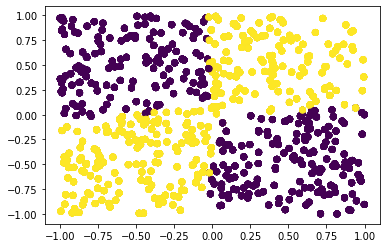

In [50]:
torch.manual_seed(1)
np.random.seed(1)

net = torch.nn.Sequential(
    torch.nn.Linear(2, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 2),
    torch.nn.Softmax(dim=1)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

learning_rate = 0.05
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

num_iter = 20
batch_size = 64

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    net.eval()
    for batch in range(int(X_train_xor.shape[0] / batch_size)):
        X = X_train_xor[batch*batch_size:((batch+1)*batch_size),]
        y = y_train_xor[batch*batch_size:((batch+1)*batch_size),]
        y_hat = net(X)
        errors_train_iter += [torch.nn.functional.mse_loss(y, y_hat[:,0]).item()]

    for batch in range(int(X_test_xor.shape[0] / batch_size)):
        X = X_test_xor[batch*batch_size:((batch+1)*batch_size),]
        y = y_test_xor[batch*batch_size:((batch+1)*batch_size),]
        y_hat = net(X)
        errors_test_iter += [torch.nn.functional.mse_loss(y, y_hat[:,0]).item()]

    net.train()
    for batch in range(int(X_train_xor.shape[0] / batch_size)):
        X = X_train_xor[batch*batch_size:((batch+1)*batch_size),]
        y = y_train_xor[batch*batch_size:((batch+1)*batch_size),]
        y_hat = net(X)
        l = loss(y_hat[:,0], y)
        optimizer.zero_grad()
        l.mean().backward()
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    
    
    y_hat = net(X_test_xor)
    y_hat = y_hat.detach().numpy()

    y_hat[y_hat > 0.5] = 1
    y_hat[y_hat <= 0.5] = 0

    plt.scatter(x_xor_test[:,0], x_xor_test[:,1], c=y_hat[:,0])
    plt.savefig(f'{epoch}.png')



### Wizualizacja uczenia na danych xor

<img src="gif1.gif" width="500" align="center">